# GLM HMM with EM on Simulated Data

In [80]:
# Import statements
import os
import traceback
import pickle
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from LearningSession import *
from LearningChoicePredictor import *
from LearningPsychometricPredictor import *
from SyntheticHMM import *
import pandas as pd
import seaborn as sns
import ssm

## Load Results

In [81]:
def plot_psychometric_clf(clf):
    condition_inputs = [
        [0, np.nan], [1, np.nan]
        ]
    plt.figure()
    for idx, cond_in in enumerate(condition_inputs):
        delta_idx = cond_in.index(np.nan)
        X = []
        for delta in range(-35, 36):
            cond_in[delta_idx] = delta
            X.append([i for i in cond_in])
        X = np.array(X).astype(float)
        
        # Norm
        #X[:,1] = X[:,1]/30.
        
        psych_curve = clf.predict_proba(X)
        plt.plot(
            range(-35, 36), psych_curve[:,1], label=str(idx)
            )
    plt.title("Probability of Choosing Right")
    plt.legend()
    plt.xlabel("More Left Beeps >>> More Right Beeps")
    plt.ylim((0,1))
    plt.axhline(0.5, color="gray")
    plt.axvline(0, color="gray")
    plt.show()

def plot_psychometric_coefs(coefs):
    for coef in coefs:
        clf = LogisticRegression()
        clf.coef_ = np.array([coef[:-1]])
        clf.intercept_ = np.array([coef[-1]])
        plot_psychometric_clf(clf)

In [82]:
def find_best_p_weight(results):
    """
    Assuming results is a dictionary over prior weights. Each entry
    of the dictionary is a list of 20 runs of the GLMHMM
    """
    
    best_p_weight = None
    best_score = -np.inf
    for p_weight in results.keys():
        sample_glmhmms = results[p_weight]
        sample_scores = [s['test_ll'] for s in sample_glmhmms]
        score = max(sample_scores)
        if score > best_score:
            best_p_weight = p_weight
            best_score = score
    return best_p_weight

In [61]:
filename = "habanero_results/inittrans0.5_prevbiased2state_results"
all_results = pickle.load(open(
    filename + ".p", "rb"
    ))
true_hmm = all_results['true_hmm']
results_K = all_results['results_K']
results_dsize = all_results['results_dsize']

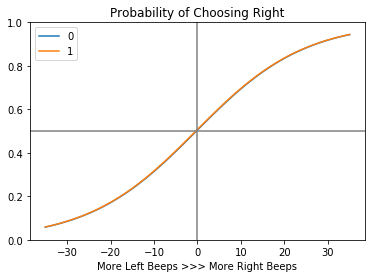

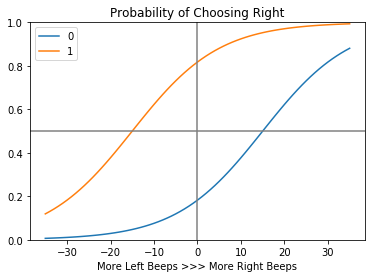

In [62]:
plot_psychometric_coefs(true_hmm.coefs)

## Test performance in predicting choice

In [63]:
def predict(hmm, X, y):
    states = hmm.most_likely_states(
        y, input=X
        )
    transition_matrix = hmm.transitions.transition_matrix
    pred_y = []
    for idx, x in enumerate(X):
        if idx == 0:
            continue
        input_with_constant = np.hstack(
            (x, 1)
            )
        prev_state = states[idx - 1]
        transition_probs = transition_matrix[prev_state,:]
        expected_ps = 0
        
        # Overestimate:
#         curr_state = states[idx]
#         logit_ps = input_with_constant @ hmm.observations.coef[curr_state]
#         ps = 1/(1 + np.exp(-1*logit_ps))
#         expected_ps = ps
        
        # Underestimate
        for new_state, transition_prob in enumerate(transition_probs):
            logit_ps = input_with_constant @ hmm.observations.coef[new_state]
            ps = 1/(1 + np.exp(-1*logit_ps))
            expected_ps += ps*transition_prob
            
        if expected_ps > 0.5:
            pred_y.append(1)
        else:
            pred_y.append(0)
    return np.array(pred_y)

## Test performance as a function of latent dimension

In [64]:
# Collect log likelihoods
test_lls = []
Ks = []
for K in results_K.keys():
    results = results_K[K][p_weight]
    for result in results:
        test_lls.append(result['test_ll'])
        Ks.append(K)
df = pd.DataFrame({
    'Ks': Ks, 'test_lls': test_lls
    })

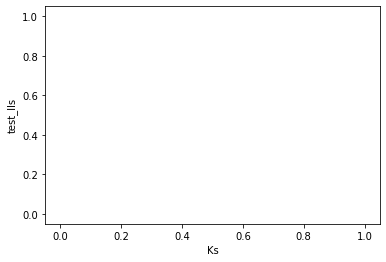

In [42]:
# Plot Log-Likes as a function of dimensions
sns.lineplot(
    x="Ks", y="test_lls", data=df
    )

## Test performance as a function of data size

In [43]:
# Collect log likelihoods
test_lls = []
dsizes = []
pred_scores = []
for dsize in results_dsize.keys():
    p_weight = find_best_p_weight(results_dsize[dsize])
    results = results_dsize[dsize][p_weight]
    for result in results:
        X_test = result['X_test']
        y_test = result['y_test']
        test_lls.append(result['test_ll']/y_test.size)
        dsizes.append(dsize)
        hmm = result['hmm']
        pred_choices = predict(hmm, X_test, y_test)
        true_choices = y_test.flatten()[1:]
        pred_score = np.sum(pred_choices == true_choices)/true_choices.size
        pred_scores.append(pred_score)
df = pd.DataFrame({
    'dsizes': dsizes, 'test_lls': test_lls, 'pred_scores': pred_scores
    })

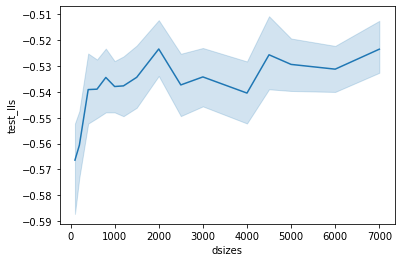

In [44]:
# Plot Log-Likes as a function of datasize
sns.lineplot(
    x="dsizes", y="test_lls", data=df
    )

(0.5, 1.0)

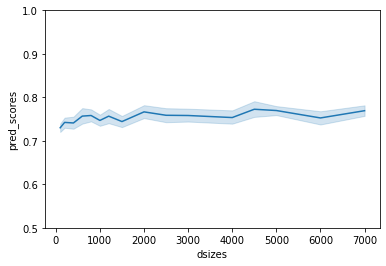

In [45]:
# Plot Accuracy as a function of datasize
sns.lineplot(
    x="dsizes", y="pred_scores", data=df
    )
plt.ylim((0.5, 1.0))

## Comparing inferred psychometric curves

In [46]:
results_dsize.keys()

dict_keys([100, 200, 400, 600, 800, 1000, 1200, 1500, 2000, 2500, 3000, 4000, 4500, 5000, 6000, 7000])

In [47]:
results = results_dsize[4500][p_weight]
results_test_lls = [r['test_ll'] for r in results]
hmm = results[np.argmax(results_test_lls)]['hmm']

In [60]:
np.exp(true_hmm.log_Ps)

array([[0.96470641, 0.03529359],
       [0.02991731, 0.97008269]])

In [58]:
np.exp(hmm.transitions.params)

array([[[0.79823189, 0.20176811],
        [0.06311024, 0.93688976]]])

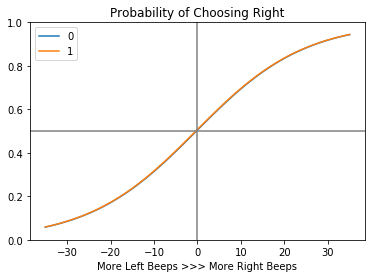

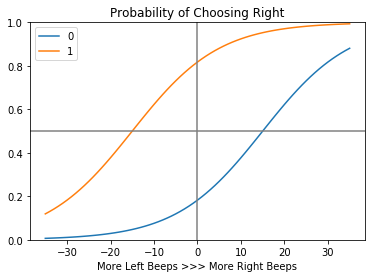

In [48]:
plot_psychometric_coefs(true_hmm.coefs)

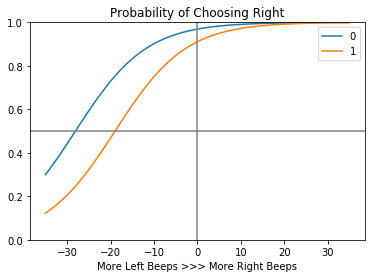

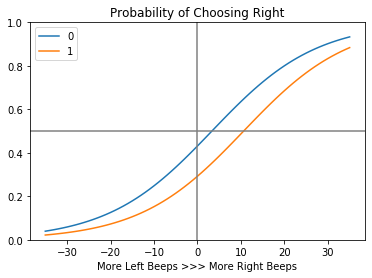

In [49]:
plot_psychometric_coefs(hmm.observations.coef)

## Testing accuracy: predicted states and predicted choices

In [50]:
result.keys()

dict_keys(['hmm', 'lls', 'test_ll', 'X_train', 'y_train', 'X_test', 'y_test', 'z_train', 'z_test'])

In [51]:
# Load test data
X_train = result['X_train']
y_train = result['y_train']
z_train = result['z_train']
X_test = result['X_test']
y_test = result['y_test']
z_test = result['z_test']

In [52]:
X_train = np.copy(X_train).astype(float)
X_train[:,1] = X_train[:,1]/30.
predicted = hmm.most_likely_states(
    y_train, input=X_train
    ) + 1
expected = z_train[1:] + 1

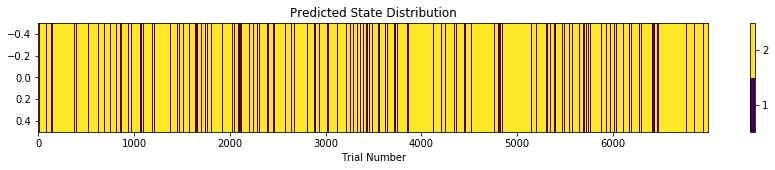

In [53]:
plt.figure(figsize=(15,2))
plt.imshow(
    predicted.reshape((1,-1)),
    aspect="auto")
plt.xlabel("Trial Number")
plt.title("Predicted State Distribution")
K = 2
plt.colorbar(boundaries=np.arange(K+1)+0.5, ticks=np.arange(K)+1)
plt.show()

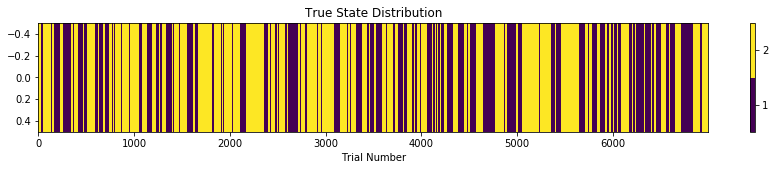

In [54]:
plt.figure(figsize=(15,2))
plt.imshow(
    expected.reshape((1,-1)),
    aspect="auto")
K = 2
plt.colorbar(boundaries=np.arange(K+1)+0.5, ticks=np.arange(K)+1)
plt.xlabel("Trial Number")
plt.title("True State Distribution")
plt.show()

In [55]:
print("Proportion Identical")
print(np.sum(predicted == expected)/predicted.size)
print(np.sum(np.logical_not(predicted.astype(bool)) == expected.astype(bool))/predicted.size)

Proportion Identical
0.5195027861123017
0.0


## Examining distribution of training data

In [121]:
# Collect training data infor
min_x = min(X_train[:,1])
max_x = max(X_train[:,1])
prev0 = []
prev1 = []
for x in X_train:
    prev = x[0]
    beeps = x[1]
    if prev == 1:
        prev1.append(beeps)
    else:
        prev0.append(beeps)

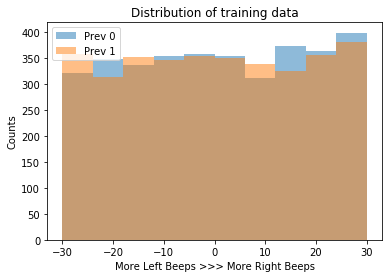

In [122]:
# Plot training data distribution
plt.figure()
plt.hist(prev0, label="Prev 0", alpha=0.5)
plt.hist(prev1, label="Prev 1", alpha=0.5)
plt.xlabel("More Left Beeps >>> More Right Beeps")
plt.ylabel("Counts")
plt.legend()
plt.title("Distribution of training data")
plt.show()

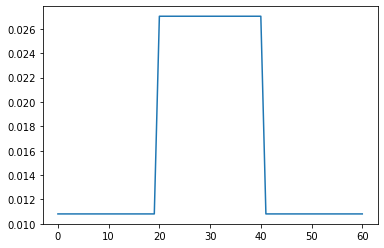

In [174]:
from sklearn.preprocessing import normalize
x = np.ones(61)
x[20:41] += 1.5
pdd = x/np.sum(x)
plt.plot(pdd)